## Imports

The $AR(p)$ model is purely written with numpy.

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

### Auxilary functions

In [48]:
def plot_data(data):

    plt.figure(1, figsize=(16,4))
    plt.plot(data)
    plt.xlim(len(data[:50000]), len(data))
    
    return True

def plot_2d_data(data, title=""):


    threshold = 0.5
    # Plotting the distribution of wind velocities
    root = int(len(data)**(1/2))
    root_data = np.array(data[:root**2]).reshape(root,root)

    
    # Normalizing
    root_data /= np.max(root_data)

    wind_gusts = np.where(root_data>threshold, 1, 0)
    #root_data **= 2
    root_data = np.exp(root_data)

    # Plotting
    fig, axs = plt.subplots(1,3, figsize=(16,4))
    axs[0].imshow(root_data, cmap="gray")
    axs[0].set_title("Wind fluctuations")

    axs[1].imshow(wind_gusts, cmap="gray")
    axs[1].set_title(f"Wind fluctuations over {threshold*100:.0f}%")

    axs[2].hist(data, bins=20)
    axs[2].set_yscale("log")
    axs[2].set_title("Probability density $p_x$")
    
    fig.suptitle(f"{title}")

    return True

### Create Surrogated Data

The surrogated dataset is only used to validate the functionality of the $AR(p)$ model. The dataset is created using itself an $AR(p=3)$ model with predefined coefficients $\phi_{1...3}$ The model should derive the right coefficients back from drawing statistical inferences from the dataset.

$\displaystyle AR(x_t)=\phi_1x_{t-1}+\phi_2x_{t-2}+\phi_3x_{t-3}+w_t$

In [89]:
rng = np.random.default_rng(11)

# Random start data
data = [1, 0, -1]
ar_coefficients = [0.4, 0.2, 0.15]

def create_artificial_data(n_data=2e+6):

    for _ in range(int(n_data)):
        white_noise = rng.standard_normal()
        result = sum([x*p for x, p in zip(reversed(data), ar_coefficients)])
        result += white_noise
        data.append(result)
        
    return np.array(data)

surrogated_data = create_artificial_data()

### Load Data

Loads the FINO1 wind velocity data.

In [90]:
DIRNAME = os.path.abspath("")
PLOTS_PATH = os.path.join(DIRNAME, "Plots")
DATA_DIR = os.path.join(os.path.dirname(DIRNAME), "FINO1Data")

os.makedirs(PLOTS_PATH, exist_ok=True)

datasets = {path.replace(".npy", ""): np.load(os.path.join(DATA_DIR, path), allow_pickle=True) for path in os.listdir(DATA_DIR) if path.endswith("npy")}

In [91]:
# Surrogated data is already stationary
datasets["surrogated data"] = surrogated_data

#### Lerp (linear interpolation)

Gets rid of the NaN's by replacing them with a linear line.

In [92]:
# Implementing Lerp (linear interpolation)
def lerp(data):
    
    ok = ~np.isnan(data)
    xp = ok.nonzero()[0]
    fp = data[ok]
    x = np.isnan(data).nonzero()[0]
    data[~ok] = np.interp(x, xp, fp)

    return data

### Pre-Analysis

General statistics of the datasets, probability density

In [93]:
for key, dataset in datasets.items():

    print(f"Dataset: {key}")
    print(f"NaNs: {np.isnan(dataset).sum()}")
    print("\n")

Dataset: 2015-2017_90m
NaNs: 183884


Dataset: 1509_100m
NaNs: 2633


Dataset: 1509_60m
NaNs: 2633


Dataset: 2015-2017_60m
NaNs: 54537


Dataset: 2015-2017_100m
NaNs: 54578


Dataset: 1509_30m
NaNs: 1908


Dataset: 2015-2017_30m
NaNs: 183887


Dataset: surrogated data
NaNs: 0




In [108]:
# Removing NaNs with linear interpolation
datasets = {key: lerp(value) for key, value in datasets.items()}

In [109]:
# Statistics of wind data
for key, dataset in datasets.items():

    print(f"Dataset: {key}: ")
    print(f"Max velocity: {dataset.max():.4f}")
    print(f"Min velocity: {dataset.min():.4f}")
    print(f"Length of dataset: {len(dataset)}")
    print("\n")

Dataset: 2015-2017_90m: 
Max velocity: 15.2161
Min velocity: -14.9254
Length of dataset: 52531199


Dataset: 1509_100m: 
Max velocity: 4.0584
Min velocity: -3.8555
Length of dataset: 2591999


Dataset: 1509_60m: 
Max velocity: 7.2472
Min velocity: -7.2472
Length of dataset: 2591999


Dataset: 2015-2017_60m: 
Max velocity: 14.2411
Min velocity: -13.5822
Length of dataset: 52531199


Dataset: 2015-2017_100m: 
Max velocity: 17.2853
Min velocity: -16.8069
Length of dataset: 52531199


Dataset: 1509_30m: 
Max velocity: 6.3806
Min velocity: -6.7351
Length of dataset: 2591999


Dataset: 2015-2017_30m: 
Max velocity: 12.3395
Min velocity: -12.6950
Length of dataset: 52531199


Dataset: surrogated data: 
Max velocity: 6.2841
Min velocity: -5.9599
Length of dataset: 2000002




The differentiation of the time series $v_t$ and $v_{t+1}$ leads to a time series of wind fluctuations $u_t$:

$\displaystyle u_t=v_{t+1}-v_t$

The probability density $p_u$ of $u_t$ is a stretched-exponential-distribution.

In [110]:
# Differentiation to make data stationary
datasets = {key: dataset[1:] - dataset[:-1] for key, dataset in datasets.items()}

In [111]:
for key, dataset in datasets.items():

    print(f"Dataset: {key}: ")
    print(f"Max fluctuation: {dataset.max():.4f}")
    print(f"Min fluctuation: {dataset.min():.4f}")
    print("\n")

Dataset: 2015-2017_90m: 
Max fluctuation: 29.8508
Min fluctuation: -20.1722


Dataset: 1509_100m: 
Max fluctuation: 6.3920
Min fluctuation: -6.7978


Dataset: 1509_60m: 
Max fluctuation: 11.0989
Min fluctuation: -10.9976


Dataset: 2015-2017_60m: 
Max fluctuation: 27.7220
Min fluctuation: -16.7018


Dataset: 2015-2017_100m: 
Max fluctuation: 33.5119
Min fluctuation: -22.9626


Dataset: 1509_30m: 
Max fluctuation: 10.1280
Min fluctuation: -10.9382


Dataset: 2015-2017_30m: 
Max fluctuation: 24.9330
Min fluctuation: -15.2340


Dataset: surrogated data: 
Max fluctuation: 9.8345
Min fluctuation: -10.2148




#### Splitting the Dataset

In [112]:
# Active dataset
dname = "2015-2017_100m"
dataset = datasets[dname]


# Split
test_set_size = min(1000000, int(len(dataset) * 0.5))
train_data = dataset[:-test_set_size]
test_data = dataset[-test_set_size:]

print(f"Split up the dataset into {len(train_data)} training examples and {len(test_data)} testing examples.")

Split up the dataset into 51531198 training examples and 1000000 testing examples.


## $AR(p)$ Model

#### Autocovariance

The autocovariance calculates the covariance of two points $x_t$ and $x_{t+\tau}$  of the same time series. Here, $\tau$ is the number of lags.

$\displaystyle Cov({x_t,x_{t+\tau}})=(x_t-\mu_x)(x_{t+\tau}-\mu_x)$

In [113]:
def autocovariance(data, lag):
    
    cov = (data - data.mean())[lag:] * (data - data.mean())[:-lag]
    return cov.mean()

# Yule-Walker Equation takes 1 seconds 

#### Autocorrelation function

Hereby $\gamma_x(\tau)$ is the autocovariance of every point to the offset of $\tau$.

$\displaystyle p_x(t_1,t_2)=p_x(\tau)=\frac{\gamma_x(\tau)}{\gamma_x(0)}$

In [114]:
lags = range(1,7)
n_coffs = len(lags)

def get_phis(train_data):

    # Autocorrelation function + addition of an error value
    acf = [autocovariance(train_data, lag) / train_data.std()**2 + 1e-6 for lag in lags]
    # [print(f"Autocorrelation function lag({lag}): {acf[lag-1]:.4f}") for lag in lags]
    
    # Yule-Walker equation with autocorrelation function
    acf.insert(0, 1.)
    r = [acf[abs(-k+j)] for k in range(n_coffs) for j in range(n_coffs)]
    acf.pop(0)
    r_matrix = (np.array(r).reshape(n_coffs, n_coffs))

    # print(f"\nR Matrix: \n {r_matrix}")

    r_inv_matrix = np.linalg.inv(r_matrix)
    phi_hats = r_inv_matrix @ np.array(acf).reshape(n_coffs, 1)

    #print("\n")
    #print(f"Phi hats: \n {phi_hats}")
    return phi_hats.flatten()

phi_hats = get_phis(test_data)
print(phi_hats)

[-0.85029478 -0.80144777 -0.66299221 -0.50355429 -0.33246391 -0.16928739]


$\displaystyle SMA=\frac{1}{k}\sum_{i=t-k+1}^tx_i$

$\displaystyle {SMA}_{k, next} = SMA_{k, prev} + \frac{1}{k}\left(x_{t+1}-x_{t-k+1}\right)$

TODO include the proof 

In [241]:
def get_sma(data, q=3):
 
    ok = ~np.isnan(data)
    data[~ok] = .0
    denominators = np.convolve(ok, np.ones(q), "valid")
    denominators[~(denominators>0)] += 1

    sma = np.convolve(data, np.ones(q), "valid")
    sma /= denominators

    return sma

get_sma(np.array([1,2,3,np.nan, np.nan, np.nan, np.nan, 4, 5]))


array([2. , 2.5, 3. , 0. , 0. , 4. , 4.5])

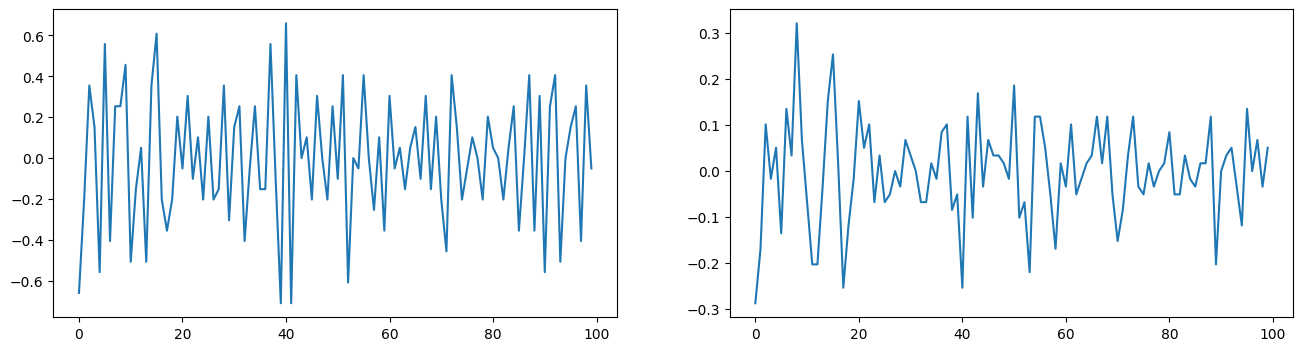

In [127]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(train_data[:100])
ax2.plot(get_sma(train_data)[:100])

When the time series is not stationary: $\hat{\phi}_1$ is close to 1, whereas $\hat{\phi}_{others}$ are close to 0. This means that the next time step is almost completly determind by $x_{t-1}$.

## Model Forecast

In [128]:
train_per = 20
gust_th = 1.6

q = 3 # rolling moving average
n = len(train_data)
l = len(phi_hats) # overlap size

start_indices = np.arange(0, n-train_per-2, train_per) # Cut off the last two for avoiding errors
indices = start_indices[:, None] + np.arange(train_per+l)
train_data_intervals = train_data[indices]


start_indices = np.arange(0, n-train_per-2, train_per) # Cut off the last two for avoiding errors
indices = start_indices[:, None] + np.arange(train_per+q)
train_data_sma = train_data[indices]
train_data_sma.shape

(2576559, 23)

$AR(p) = \phi_1x_{t-1}+\phi_2x_{t-2}+\phi_3x_{t-3}+{\color{yellow}{w(t)}}$

$w(t) \sim \mathcal{N}(\mu, \sigma_w^2)$

In [118]:
stds = train_data_intervals[:-1].std(axis=1)
white_noise = rng.normal(size=train_data_intervals[:-1, l:].shape, scale=(stds**2)[:, None])
white_noise.shape

(2576558, 20)

In [119]:
print(stds.mean())
print(white_noise.min())
print(white_noise.max())
((2*stds**2)**0.5).mean()

0.4060327817920974
-200.89239647916975
169.55297839444776


0.574217066778459

In [120]:
phi_hats = get_phis(train_data_intervals[0])
predictions = []

for x in train_data_intervals[1:]:
    x = get_sma(x)
    prediction = np.convolve(x[:-1], phi_hats, "valid")
    predictions.append(prediction)
    phi_hats = get_phis(x)
    
predictions = np.array(predictions)

/var/folders/q5/4fw43q7s02j4ymzfzqf9t82c0000gn/T/ipykernel_42493/1805032564.py:7: RuntimeWarning: invalid value encountered in double_scalars
  acf = [autocovariance(train_data, lag) / train_data.std()**2 + 1e-6 for lag in lags]


In [67]:
# _ = plt.figure(1, figsize=(16,5))
# plt.plot(train_data_intervals[1:, l:].flatten()[:])
# plt.plot(predictions.flatten()[:], alpha=0.8)
# plt.ylim(-10,10)

In [121]:
predictions += white_noise

ValueError: operands could not be broadcast together with shapes (2576558,18) (2576558,20) (2576558,18) 

Text(0, 0.5, 'fluctuation in (m/s)')

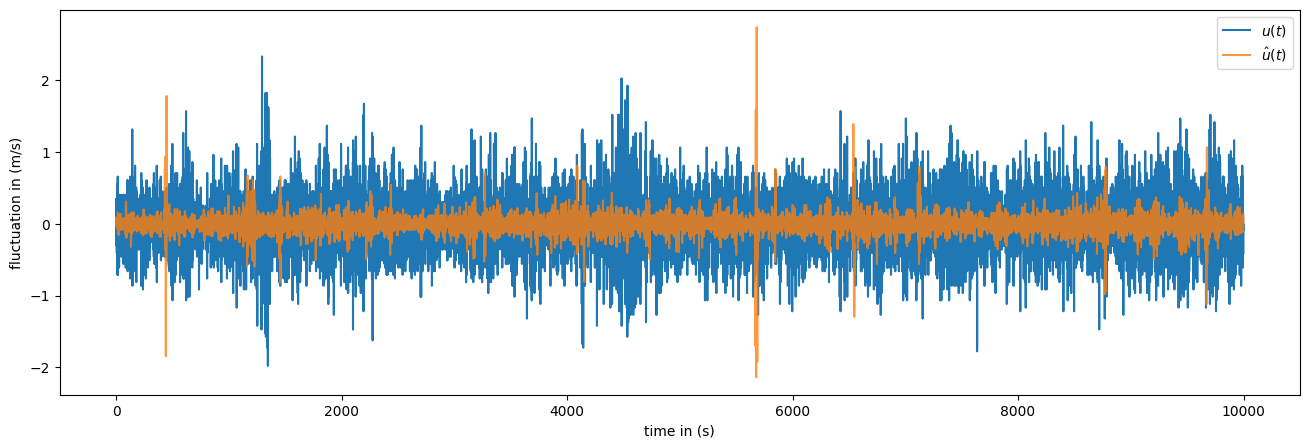

In [122]:
_ = plt.figure(1, figsize=(16,5))
plt.plot(train_data_intervals[1:, l:].flatten()[:10000], label="$u(t)$")
plt.plot(predictions.flatten()[:10000], alpha=0.8, label="$\hat{u}(t)$")
plt.legend()
plt.xlabel("time in (s)")
plt.ylabel("fluctuation in (m/s)")

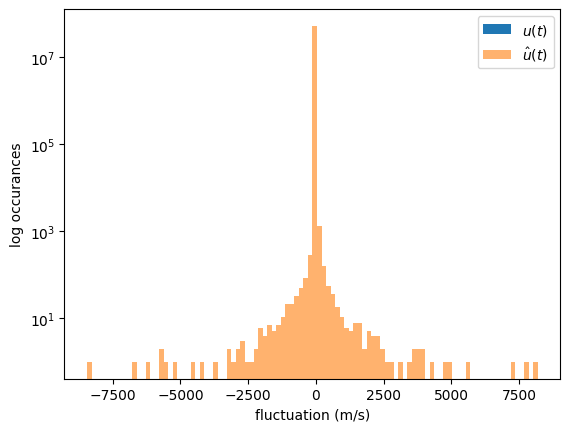

In [70]:
plt.hist(train_data_intervals[1:, l:].flatten(), bins=100, label="$u(t)$");
plt.hist(predictions.flatten(), bins=100, label="$\hat{u}(t)$", alpha=0.6);
plt.legend()
plt.xlabel("fluctuation (m/s)")
plt.ylabel("log occurances")
plt.yscale("log")

In [71]:
n_gusts = np.where(train_data_intervals[1:, l:] > gust_th, 1, 0).sum()
n_gusts

2766

In [72]:
n_gusts = np.where(predictions.flatten() > gust_th, 1, 0).sum()
n_gusts

52499

The integral of the Gaussian bell is called $\operatorname{erf(x)}$. 

$\displaystyle P\left(\hat{u}(t)> u_x\right)=\frac{1}{2}\left[1-\operatorname{erf}\left(\frac{u_x-\hat{u}(t)}{\sqrt{2\sigma_w^2(t)}}\right)\right]$

In [73]:
from scipy import special

z = (gust_th - predictions) / ((2*stds**2)**0.5)[:, None]
pred_integral = 0.5 * (1 - special.erf(z))

In [74]:
np.argmax(pred_integral.max(axis=1))

35983

Text(0, 0.5, 'Exceeding probability: $P(\\hat{u}(t)>u_x)$')

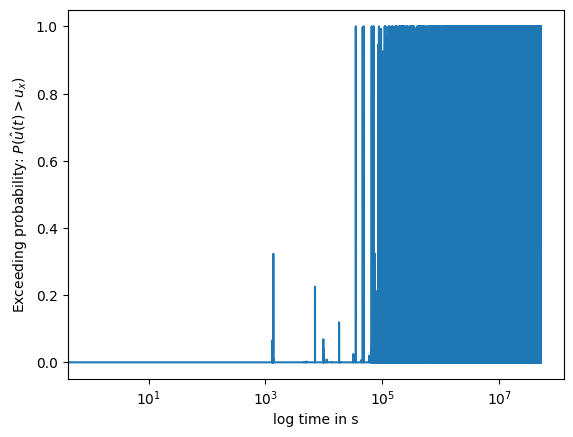

In [75]:
plt.semilogx(pred_integral.flatten())
plt.xlabel("log time in s")
plt.ylabel("Exceeding probability: $P(\hat{u}(t)>u_x)$")

Text(0, 0.5, 'Log occurances')

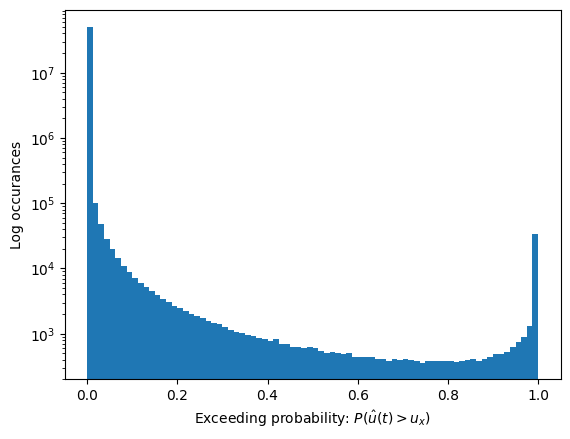

In [76]:
pred_integral = pred_integral.flatten()
plt.hist(pred_integral, bins=80);
plt.yscale("log")
plt.xlabel("Exceeding probability: $P(\hat{u}(t)>u_x)$")
plt.ylabel("Log occurances")

$\displaystyle G(t) = \begin{cases} 3 & u(t) > u_x \\ 1 & u(t) < u_x \end{cases}$

$P\left(\hat{u}(t) > u_x\right)$


$\displaystyle \hat{G}(t) = \begin{cases} 1 & Q > 0.75 \\ 0 & Q < 0.75\end{cases}$

In [77]:
np.argmax(train_data_intervals.max(axis=1))

557137

In [78]:
# _ = plt.figure(1, figsize=(16,8))
# plt.plot(train_data_intervals[1:, l:].flatten()[-127076:-1300])
# plt.plot(predictions.flatten()[-127076:-1300], alpha=0.6)

In [79]:
quantiles = 1/np.exp(np.linspace(0, 40, 20))[::-1]
wind_gusts = np.where(train_data_intervals[1:, l:].flatten() >= gust_th, 3, 0) # G(t)
n_gusts = np.where(wind_gusts == 3, 1, 0).sum()

In [80]:
performances2 = dict.fromkeys(quantiles)

for quantile in quantiles:

    wind_gusts_pred = np.where(pred_integral >= quantile, 1, 0) 
    # 3, 0
    # 1, 0

    true_positive = np.where(wind_gusts_pred + wind_gusts == 4, 1, 0)
    false_positive = np.where(wind_gusts_pred + wind_gusts == 1, 1, 0)
    
    true_positive_rate = true_positive.sum() / n_gusts
    false_positive_rate = false_positive.sum() / (len(wind_gusts) - n_gusts)

    performances2[quantile] = (true_positive_rate, false_positive_rate)


In [81]:
# OLD VERSION
thresholds = np.linspace(-1, 1, 35)
performances = dict.fromkeys(thresholds)

# Actual occurance: wind gust
wind_gusts = np.where(train_data_intervals[1:, l:].flatten() >= gust_th, 3, 0)
n_gusts = np.where(wind_gusts == 3, 1, 0).sum()

for threshold in thresholds:


    # Model prediction: wind gust
    wind_gusts_pred = np.where(predictions.flatten() >= threshold, 1, 0)
    # 3, 0
    # 1, 0

    accuracies = []
    true_positive = np.where(wind_gusts_pred + wind_gusts == 4, 1, 0)
    false_positive = np.where(wind_gusts_pred + wind_gusts == 1, 1, 0)
    
 
    true_positive_rate = true_positive.sum() / n_gusts
    false_positive_rate = false_positive.sum() / (len(wind_gusts)-n_gusts)
    
    accuracies.append(true_positive_rate)
    accuracies.append(false_positive_rate)


    performances.update({threshold: accuracies})

## ROC-curve (Receiver operating characteristic-curve)

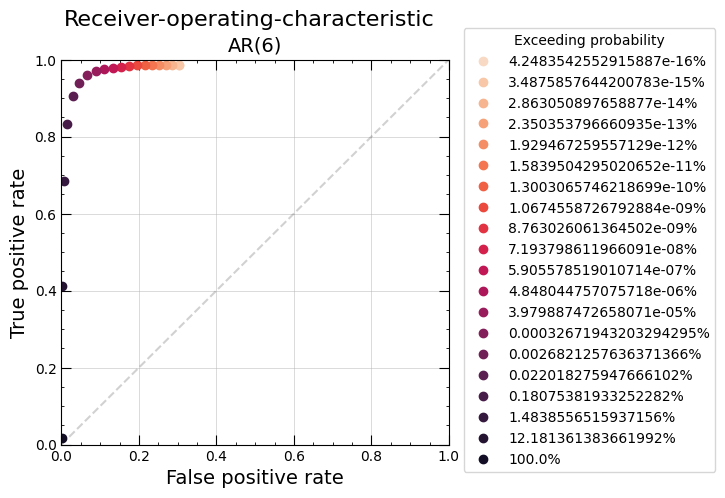

In [103]:
colors = sns.color_palette("rocket_r", len(performances2))

fig = plt.figure(1, figsize=(5,5))

i = 0
for threshold, (true_positive_rate, false_positive_rate) in performances2.items():
    plt.plot(false_positive_rate, true_positive_rate, "o", label=f"{quantiles[i]*100}%", color=colors[i])
    i += 1
plt.plot(np.arange(2), linestyle="--", color='#0f0f0f30')


plt.grid(linewidth=0.4, alpha=0.8)
plt.xlim(0,1)
plt.ylim(0,1)

plt.minorticks_on()
plt.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
plt.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)
plt.xlabel("False positive rate", fontsize=14)
plt.ylabel("True positive rate", fontsize=14)

plt.title(f"AR({n_coffs})", fontsize=14)
plt.suptitle("Receiver-operating-characteristic", fontsize=16)
plt.legend(title="Exceeding probability", fontsize=10, bbox_to_anchor=(1.02,1.1))

#plt.savefig(os.path.join(PLOTS_PATH, f"{dname}-AR({n_coffs}).png"), format="png", dpi=300, bbox_inches="tight")

In [142]:
base_1 = np.array([.5,-.5])
base_2 = np.array([.5, .5])

points = dict()

for key, (y,x) in performances2.items():
    point = x * base_1 + y * base_2
    points[key] = point


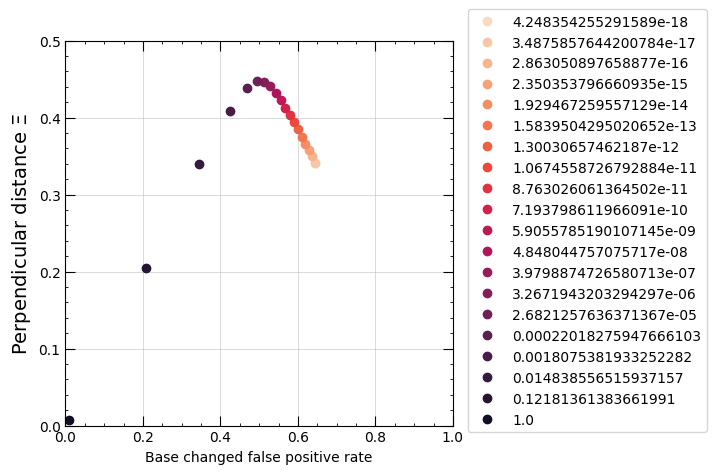

In [143]:
_ = plt.figure(figsize=(5,5))
i = 0
for threshold, (y,x) in points.items():
    plt.plot(y, x, "o", label=f"{quantiles[i]}", color=colors[i])
    i += 1

plt.plot(np.ones(2)*0.5, linestyle="--", color='#0f0f0f30')
plt.grid(linewidth=0.4, alpha=0.8)
plt.ylim(0,0.5)
plt.xlim(0,1)
plt.minorticks_on()
plt.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
plt.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)
plt.xlabel("Base changed false positive rate", fontsize=10)
plt.ylabel("Perpendicular distance $\Xi$", fontsize=14)
plt.legend(fontsize=10, bbox_to_anchor=(1.02,1.1))

In [146]:
dict(reversed(sorted(points.items(), key=lambda item:item[1][1])))

{2.6821257636371367e-05: array([0.49333831, 0.44700876]),
 3.2671943203294297e-06: array([0.51299529, 0.44651303]),
 3.9798874726580713e-07: array([0.52886228, 0.44076895]),
 0.00022018275947666103: array([0.46754504, 0.43881794]),
 4.848044757075717e-08: array([0.54284312, 0.43257264]),
 5.9055785190107145e-09: array([0.55571837, 0.42331273]),
 7.193798611966091e-10: array([0.56712482, 0.41299087]),
 0.0018075381933252282: array([0.42362853, 0.4086202 ]),
 8.763026061364502e-11: array([0.5787937 , 0.40349119]),
 1.0674558726792884e-11: array([0.5904825 , 0.39469466]),
 1.30030657462187e-12: array([0.60033326, 0.38484389]),
 1.5839504295020652e-13: array([0.60977638, 0.37540077]),
 1.929467259557129e-14: array([0.6188367 , 0.36634045]),
 2.350353796660935e-15: array([0.62749473, 0.35768242]),
 2.863050897658877e-16: array([0.63574077, 0.34979792]),
 3.4875857644200784e-17: array([0.64514433, 0.34111742]),
 4.248354255291589e-18: array([0.64514433, 0.34111742]),
 0.014838556515937157: a